Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [X] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [X] Plot a confusion matrix for your Tanzania Waterpumps model.
- [X] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [X] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [X] Commit your notebook to your fork of the GitHub repo.
- [X] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [X] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [35]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [36]:
def wrangle(X):
  '''Wrangle train, validate, and test sets in the same way'''
  
  # Prevent SettingWithCopy Warning
  X = X.copy()

  # Replace near-zero outlier latitude values with zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # For columns with zeros in place of NaNs, input NaNs
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'population', 'gps_height']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

  # Remove duplicate columns
  duplicates = ['quantity_group', 'waterpoint_type_group', 'quality_group',
                'payment_type', 'extraction_type_group', 'extraction_type']
  X = X.drop(columns=duplicates)

  # Remove constant & constantly varied columns
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract components from date_recorded and drop date_recorded column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns=['date_recorded'])

  # Engineer feature: years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()



  # return wrangled dataframe
  return X

In [46]:
from sklearn.model_selection import train_test_split

# Create train, val datasets to replicate random forest model 
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'],
                              random_state=7)

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]
X_val = val_wrangled.drop(columns=target)
y_val = val_wrangled[target]
X_test = test_wrangled

In [47]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=8, max_features=.6792,
                           random_state=7)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy: %', pipeline.score(X_train, y_train)*100)
print('Validation Accuracy: %', pipeline.score(X_val, y_val)*100)

Train Accuracy: % 87.71675084175085
Validation Accuracy: % 81.06060606060606


In [60]:
y_pred = pipeline.predict(X_val)

In [37]:
# Re-pull train & test dataset to prepare for cross validation
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

# Arrange features to prepare for model fitting
X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]
X_test = test_wrangled

# Imports for randomized search and xgboost
from scipy.stats import randint, uniform 
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

#pipeline for xgboost
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier()
)

param_distributions = {
    'xgbclassifier__eta': uniform(.01, .3),
    'xgbclassifier__max_depth': randint(3, 100),
    'xgbclassifier__min_child_weight': randint(1, 50),
    'xgbclassifier__subsample': uniform(0, 1),
    'xgbclassifier__colsample_bytree': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=7
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 17.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.9min finished


In [38]:
# find best hyperparameters and best score
print('Best hyperparameters:', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters: {'xgbclassifier__colsample_bytree': 0.4774011548515884, 'xgbclassifier__eta': 0.11976711573417788, 'xgbclassifier__max_depth': 38, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.7686475065195093}
Cross-validation MAE 0.8042929292929293


In [39]:
# Generate test prediction from xgboost pipeline
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_test)

# Generate Kaggle submission csv

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('lori_thursday.csv', index=False)

# from google.colab import files
# files.download('lori_thursday.csv')

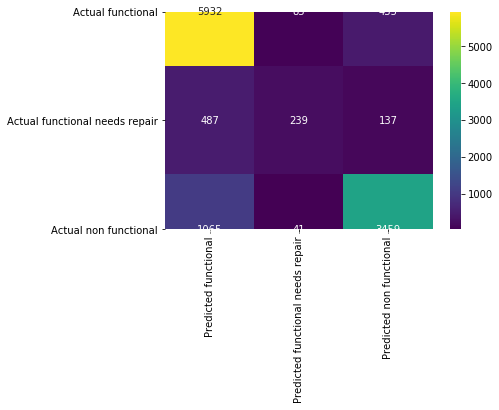

In [62]:
# Plot confusion matrix

# imports
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
             
plot_confusion_matrix(y_val, y_pred);